In [ ]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/drive/')
root_path = "/content/drive/My Drive/Dataset/"
files = os.listdir(root_path)
for file in files:
    print(file)

file_path = "PhiUSIIL_Phishing_URL_Dataset.csv"
df = pd.read_csv(root_path+file_path)



Mounted at /content/drive/
PhiUSIIL_Phishing_URL_Dataset.csv
detect_bad_url_models
fixed_overfitting_models


In [ ]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
print(df.memory_usage(deep=True).sum() / (1024**2), "MB")
print(df.info())

175.1640748977661 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64 

In [ ]:
null_values = df.isnull().sum()
print(null_values[null_values > 0])


Series([], dtype: int64)


# Xác định kiểu dữ liệu

In [ ]:
#Categorical Features

# Định danh / Tên (Identifiers)
categorical_identifiers = [
    "FILENAME", "URL", "Domain", "TLD", "Title"
]

# Phân loại dạng nhị phân (Binary Categorical Features - 0 hoặc 1)
categorical_binary = [
    "IsDomainIP", "HasObfuscation", "IsHTTPS", "HasTitle", "HasFavicon",
    "Robots", "IsResponsive", "HasDescription", "HasExternalFormSubmit",
    "HasSocialNet", "HasSubmitButton", "HasHiddenFields", "HasPasswordField",
    "Bank", "Pay", "Crypto", "HasCopyrightInfo"
]

# Phân loại dạng nhiều giá trị (Ordinal Categorical Features)
categorical_ordinal = [
    "NoOfSubDomain", "NoOfURLRedirect", "NoOfSelfRedirect",
    "NoOfPopup", "NoOfiFrame"
]

#Numerical Features

# Biến số nguyên (Discrete Numerical Features)
numerical_discrete = [
    "URLLength", "DomainLength", "TLDLength",
    "NoOfDegitsInURL", "NoOfEqualsInURL", "NoOfQMarkInURL",
    "NoOfAmpersandInURL", "NoOfOtherSpecialCharsInURL",
    "LineOfCode", "LargestLineLength", "NoOfImage", "NoOfCSS",
    "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef"
]

# Biến số thực (Continuous Numerical Features)
numerical_continuous = [
    "URLSimilarityIndex", "DomainTitleMatchScore", "URLTitleMatchScore",
    "URLCharProb", "CharContinuationRate", "DomainLength", "URLLength",
    "LetterRatioInURL", "DegitRatioInURL", "SpacialCharRatioInURL",
    "NoOfOtherSpecialCharsInURL", "NoOfLettersInURL"
]

# Kiểm tra độ dài từng nhóm đặc trưng
print("Length of Categorical Identifiers:", len(categorical_identifiers))
print("Length of Categorical Binary:", len(categorical_binary))
print("Length of Categorical Ordinal:", len(categorical_ordinal))
print("Length of Numerical Discrete:", len(numerical_discrete))
print("Length of Numerical Continuous:", len(numerical_continuous))



Length of Categorical Identifiers: 5
Length of Categorical Binary: 17
Length of Categorical Ordinal: 5
Length of Numerical Discrete: 16
Length of Numerical Continuous: 12


## Tiêu chí chọn đặc trưng (Lọc đăc trưng categorical)
- Giữ lại những đặc trưng có P-Value < 0.05 → Chúng có ý nghĩa thống kê.
- Loại bỏ những đặc trưng có P-Value > 0.05 → Không có ý nghĩa thống kê, có thể bỏ đi.
- Ưu tiên những đặc trưng có Chi2 Score cao → Đặc trưng quan trọng hơn.

In [ ]:


X_categorical = df[categorical_binary + categorical_ordinal]
y = df["label"]

# Kiểm tra giá trị NaN và xử lý nếu có
X_categorical = X_categorical.fillna(0)

# Chuẩn hóa dữ liệu trước khi tính Chi-Square (Chi2 yêu cầu dữ liệu không âm)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_categorical)

# Thực hiện Chi-Square test
chi2_values, p_values = chi2(X_scaled, y)

chi2_df = pd.DataFrame({"Feature": X_categorical.columns, "Chi2 Score": chi2_values, "P-Value": p_values})
chi2_df = chi2_df.sort_values(by="Chi2 Score", ascending=False)

from google.colab.data_table import DataTable
DataTable(chi2_df)

,Feature,Chi2 Score,P-Value
9,HasSocialNet,78811.934042,0.000000e+00
16,HasCopyrightInfo,66871.068583,0.000000e+00
7,HasDescription,62888.381682,0.000000e+00
10,HasSubmitButton,46228.267397,0.000000e+00
11,HasHiddenFields,37821.068212,0.000000e+00
4,HasFavicon,36682.457685,0.000000e+00
5,Robots,26659.697111,0.000000e+00
6,IsResponsive,26647.303233,0.000000e+00
14,Pay,23283.517866,0.000000e+00
2,IsHTTPS,19018.111861,0.000000e+00


## Phân tích tương quan (Lọc đặc trưng numerical)
- Đặc trưng có giá trị tương quan dương cao (giá trị > 0.2)
- Đặc trưng có tương quan trung bình (0.1 < x < 0.2)
- Đặc trưng có tương quan âm mạnh (giá trị < -0.2)
- Đặc trưng có tương quan gần 0 (không ảnh hưởng nhiều đến label)

<ipython-input-6-10a8be866967>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_correlation.values, y=label_correlation.index, palette="coolwarm")


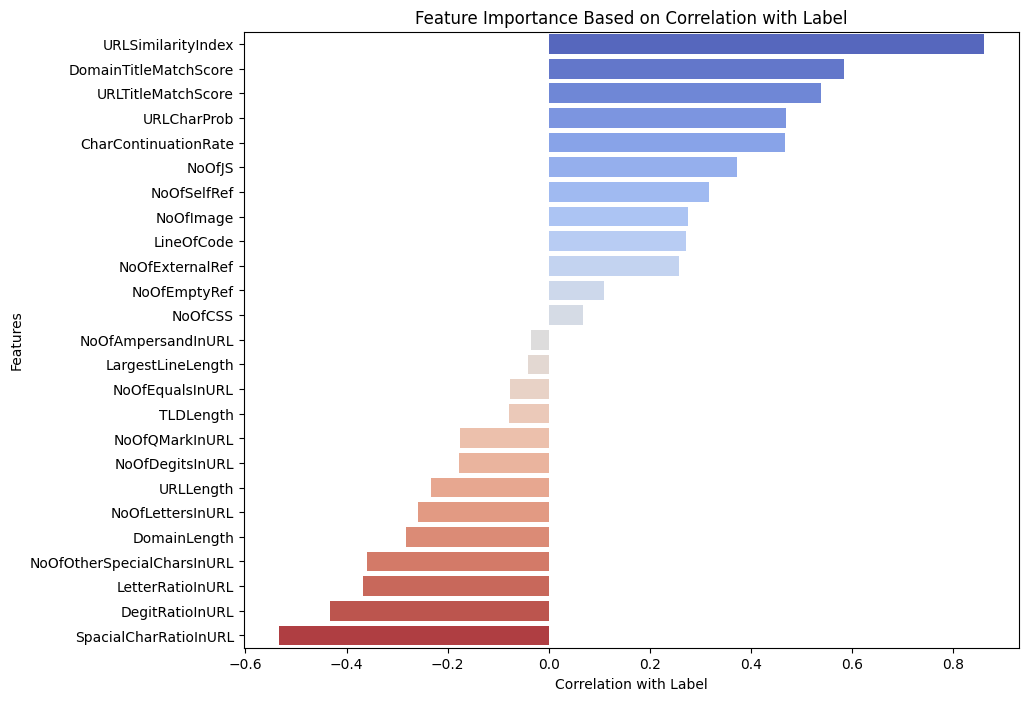

In [ ]:
# Tính toán hệ số tương quan giữa các đặc trưng số và label
correlation = df[numerical_discrete + numerical_continuous + ["label"]].corr()

# Lấy giá trị tương quan của label với các đặc trưng
label_correlation = correlation["label"].drop("label").sort_values(ascending=False)

# barplot
plt.figure(figsize=(10, 8))
sns.barplot(x=label_correlation.values, y=label_correlation.index, palette="coolwarm")
plt.xlabel("Correlation with Label")
plt.ylabel("Features")
plt.title("Feature Importance Based on Correlation with Label")
plt.show()

# Virtualize Data

In [ ]:
selected_cate_features = [
    "HasSocialNet", "HasCopyrightInfo", "HasDescription",
    "HasSubmitButton", "HasHiddenFields", "HasFavicon",
    "Robots", "IsResponsive", "Pay", "IsHTTPS",
    "Bank", "HasTitle", "HasExternalFormSubmit",
    "HasPasswordField", "Crypto",
]

selected_numerical_features = [
    "URLSimilarityIndex", "DomainTitleMatchScore", "URLTitleMatchScore",
    "URLCharProb", "CharContinuationRate",

]
selected_features = selected_cate_features + selected_numerical_features + ["label"]

df_selected = df[selected_features]

df_selected.head()
df_selected.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HasSocialNet           235795 non-null  int64  
 1   HasCopyrightInfo       235795 non-null  int64  
 2   HasDescription         235795 non-null  int64  
 3   HasSubmitButton        235795 non-null  int64  
 4   HasHiddenFields        235795 non-null  int64  
 5   HasFavicon             235795 non-null  int64  
 6   Robots                 235795 non-null  int64  
 7   IsResponsive           235795 non-null  int64  
 8   Pay                    235795 non-null  int64  
 9   IsHTTPS                235795 non-null  int64  
 10  Bank                   235795 non-null  int64  
 11  HasTitle               235795 non-null  int64  
 12  HasExternalFormSubmit  235795 non-null  int64  
 13  HasPasswordField       235795 non-null  int64  
 14  Crypto                 235795 non-nu

### Biểu đồ phân phối của các đặc trưng phân loại (Categorical Features)

<ipython-input-10-f23d72f6c265>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_selected, x=col, palette="viridis")
<ipython-input-10-f23d72f6c265>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_selected, x=col, palette="viridis")
<ipython-input-10-f23d72f6c265>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_selected, x=col, palette="viridis")
<ipython-input-10-f23d72f6c265>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

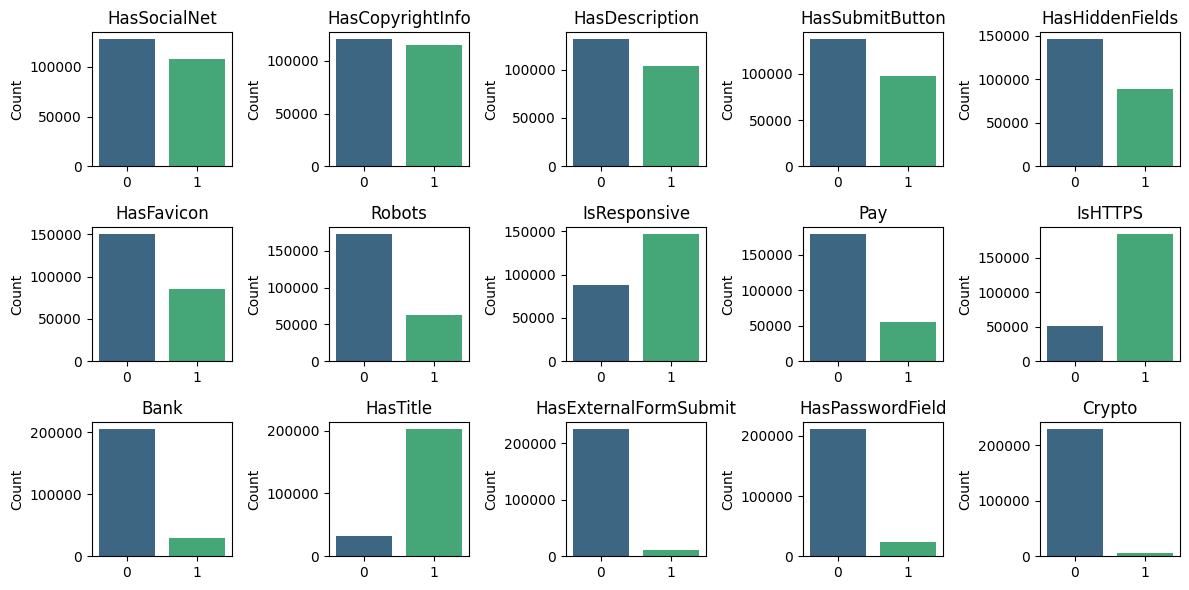

In [ ]:

plt.figure(figsize=(12, 6))

# Duyệt qua các cột phân loại và vẽ biểu đồ cột
for i, col in enumerate(selected_cate_features):
    plt.subplot(3, 5, i+1)
    sns.countplot(data=df_selected, x=col, palette="viridis")
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


### Biểu đồ phân phối của các đặc trưng số (Numerical Features)
Một số đặc trưng bị phân bố lệch mạnh:
- URLSimilarityIndex, DomainTitleMatchScore, URLTitleMatchScore , CharContinuationRate có 2 đỉnh rõ ràng (ở 0 và 100). Điều này cho thấy dữ liệu có sự mất cân bằng và có thể ảnh hưởng đến mô hình.
- URLCharProb có phân phối gần chuẩn, nhưng cũng có một số giá trị ngoại lệ.

<Figure size 1600x1200 with 0 Axes>

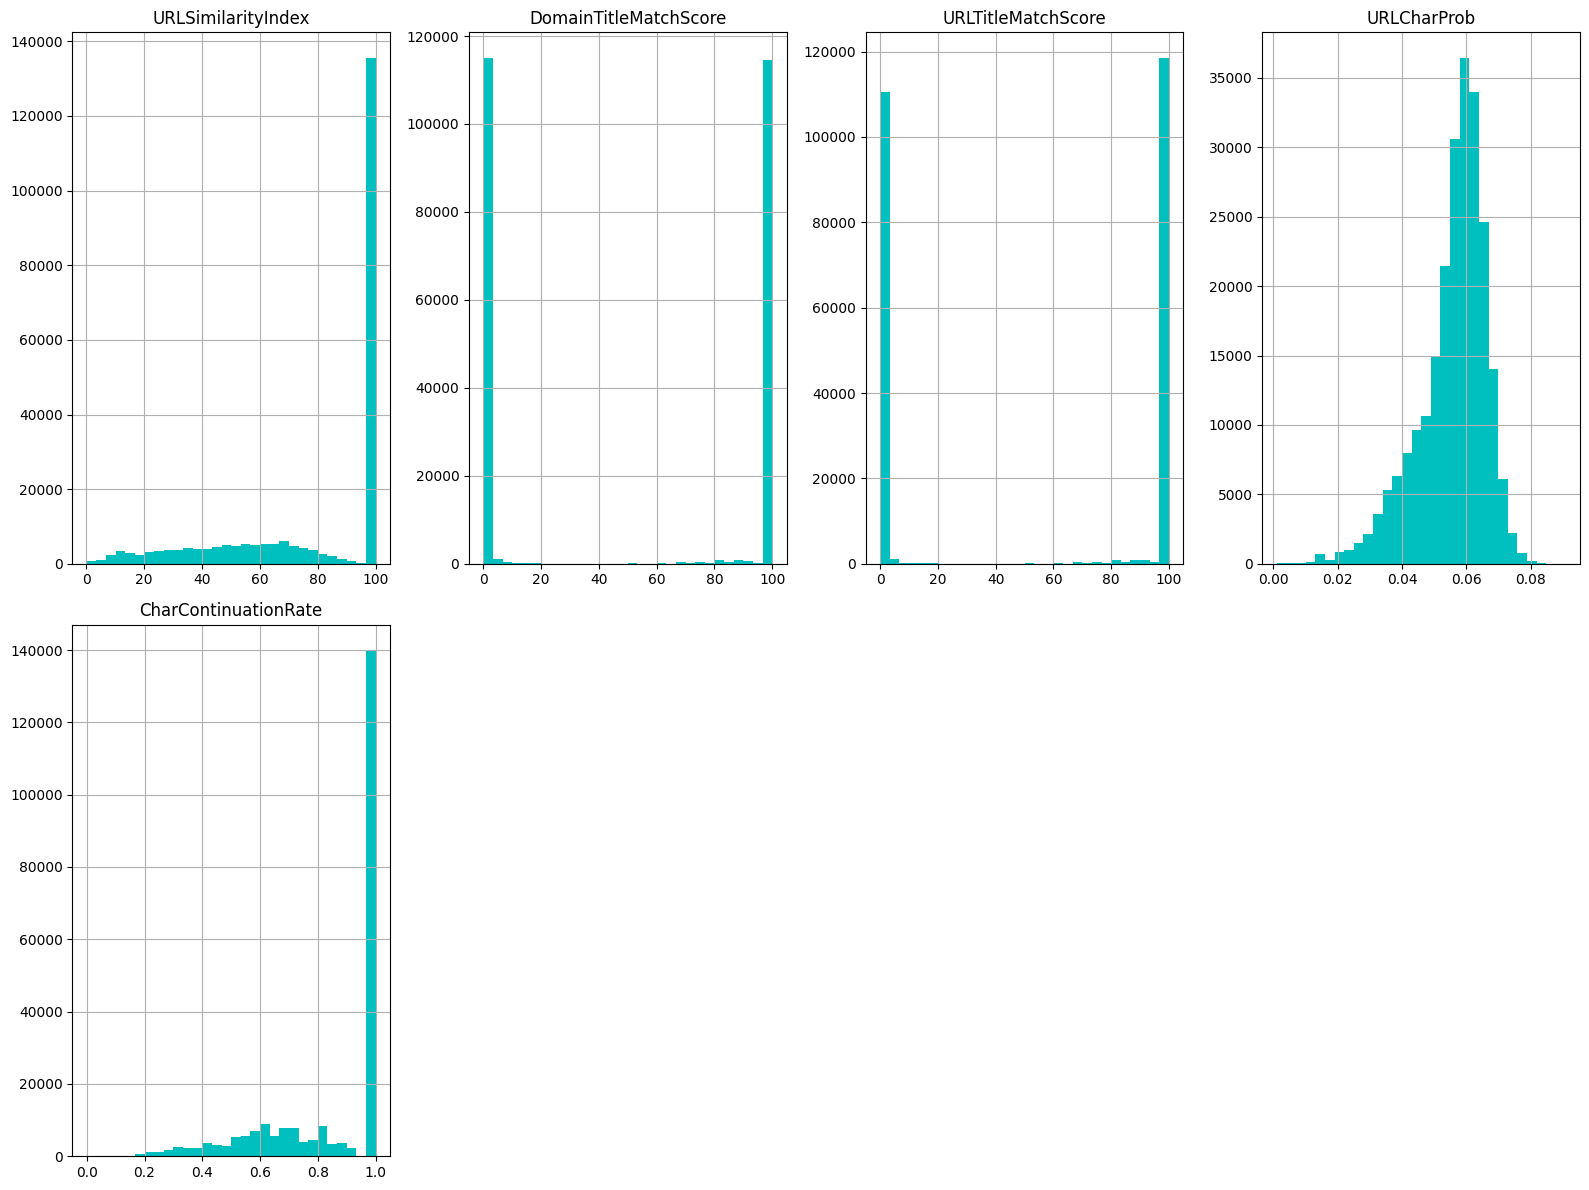

In [ ]:
# plt.figure(figsize=(12, 6))

# # Vẽ histogram cho các cột số
# df_selected[selected_numerical_features].hist(bins=30, figsize=(12, 6), layout=(2, 3), color='c')
# plt.tight_layout()
# plt.show()

num_features = len(selected_numerical_features)

# Xác định số hàng và số cột cho subplot (tạo một lưới 3x4)
rows = (num_features // 4) + (num_features % 4 > 0)  # Chia làm 4 cột
cols = 4

plt.figure(figsize=(16, 12))

df_selected[selected_numerical_features].hist(
    bins=30, figsize=(16, 12), layout=(rows, cols), color='c'
)

plt.tight_layout()
plt.show()


### Kiểm tra mối quan hệ giữa các đặc trưng và nhãn (label)
- Nhiều đặc trưng có outliers (ngoại lệ):
URLCharProb và CharContinuationRate có nhiều điểm nằm ngoài râu (whiskers), điều này có thể gây ảnh hưởng xấu đến mô hình.
- URLSimilarityIndex, DomainTitleMatchScore, URLTitleMatchScore có phạm vi trải rộng và có thể có giá trị ngoại lệ lớn.

<ipython-input-12-09aa7254d87e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-12-09aa7254d87e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-12-09aa7254d87e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-12-09aa7254d87e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

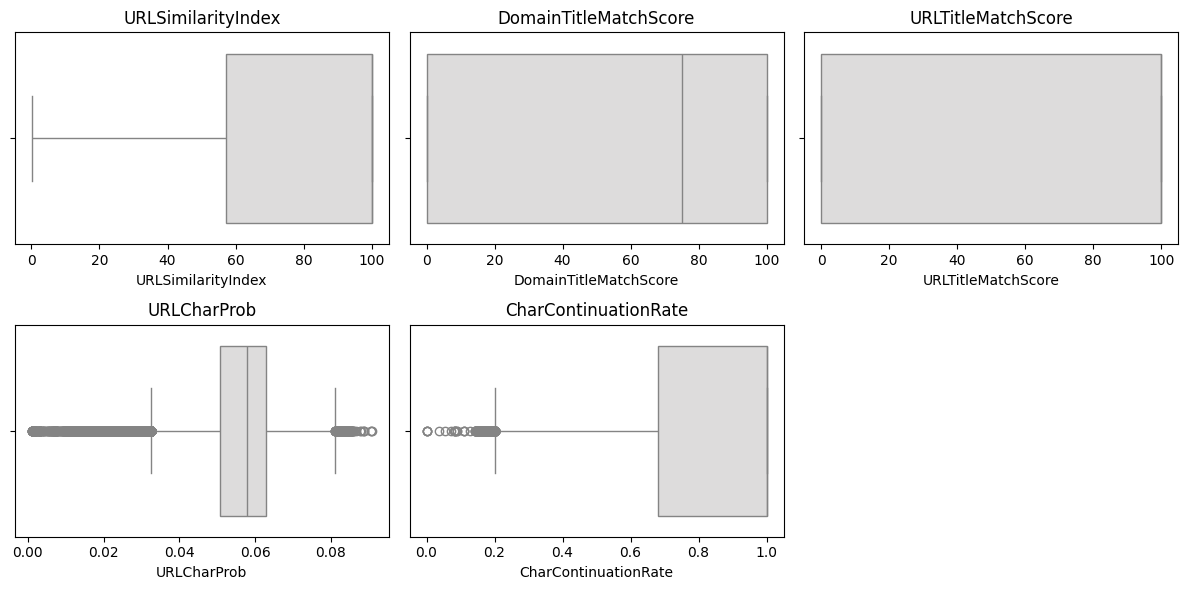

In [ ]:
plt.figure(figsize=(12, 6))

for i, col in enumerate(selected_numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df_selected, x=col, palette="coolwarm")
    plt.title(col)

plt.tight_layout()
plt.show()


## Xử lý dữ liệu lệch

In [ ]:
import numpy as np
# Áp dụng log transformation cho các đặc trưng số có giá trị dương
for col in ["URLSimilarityIndex", "DomainTitleMatchScore", "URLTitleMatchScore", "CharContinuationRate"]:
    df_selected[col] = np.log1p(df_selected[col])  # log(1 + x) để tránh log(0)


Q1 = df_selected[selected_numerical_features].quantile(0.25)
Q3 = df_selected[selected_numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng giới hạn
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc dữ liệu trong ngưỡng
df_selected = df_selected[~((df_selected[selected_numerical_features] < lower_bound) |
                            (df_selected[selected_numerical_features] > upper_bound)).any(axis=1)]


<ipython-input-13-3aa31515496b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[col] = np.log1p(df_selected[col])  # log(1 + x) để tránh log(0)


#Các đặc trưng sau khi xử lý

<Figure size 1200x600 with 0 Axes>

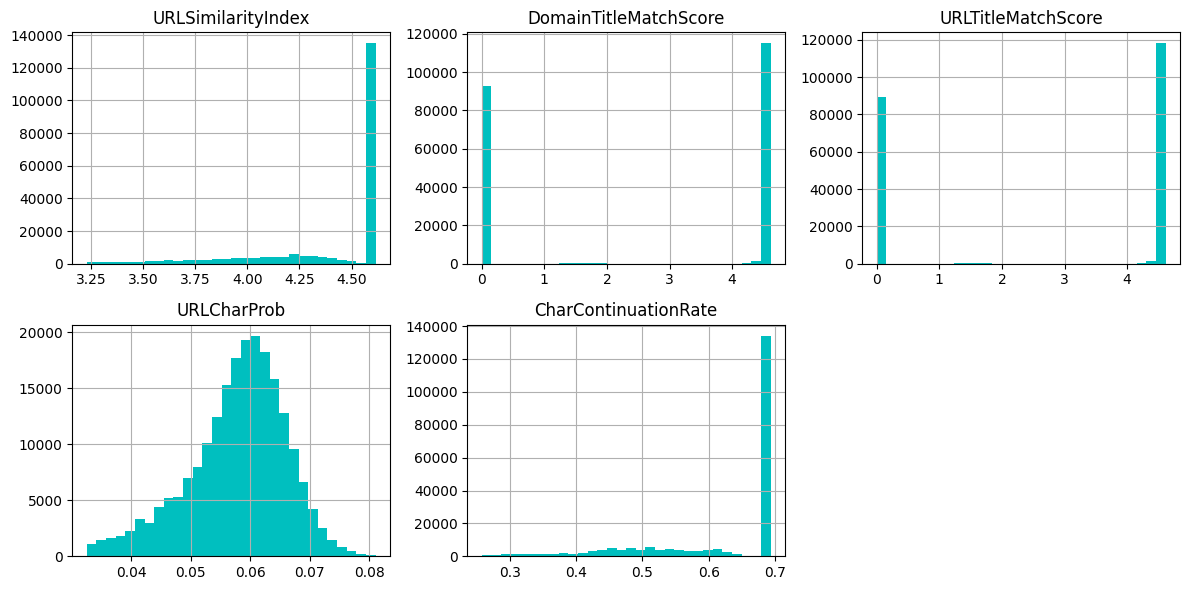

<ipython-input-14-c2c6316540fa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-14-c2c6316540fa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-14-c2c6316540fa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_selected, x=col, palette="coolwarm")
<ipython-input-14-c2c6316540fa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable t

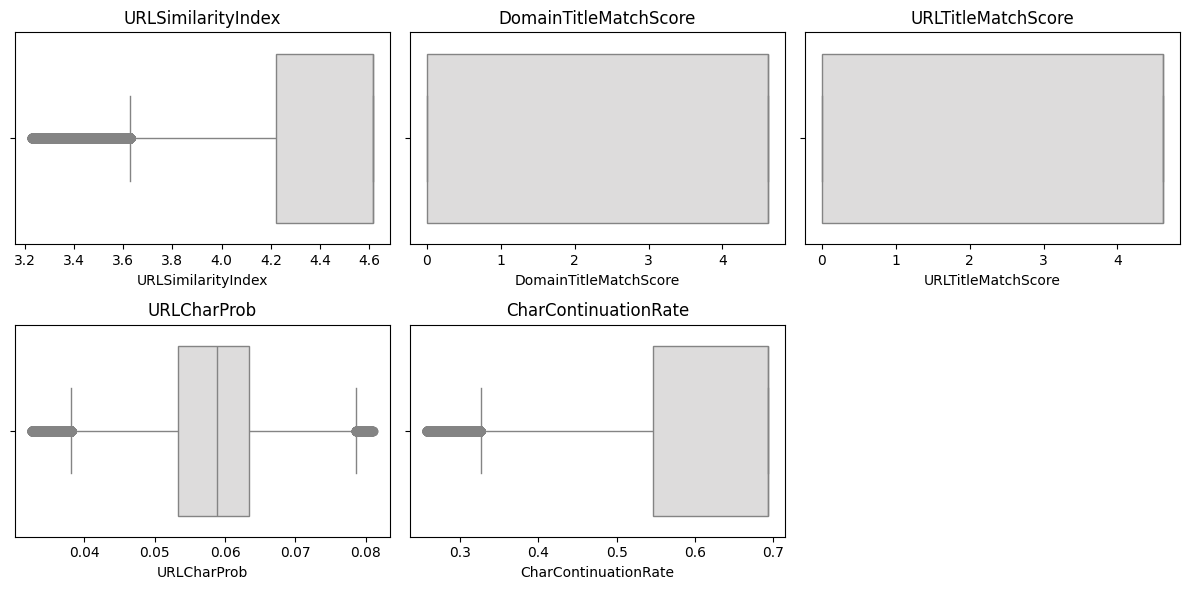

In [ ]:
plt.figure(figsize=(12, 6))

df_selected[selected_numerical_features].hist(bins=30, figsize=(12, 6), layout=(2, 3), color='c')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for i, col in enumerate(selected_numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df_selected, x=col, palette="coolwarm")
    plt.title(col)

plt.tight_layout()
plt.show()



### Kiểm tra mối quan hệ giữa các đặc trưng và nhãn (label)
Nhận xét chung về ma trận tương quan
- Màu đỏ đậm (~1.0 hoặc -1.0): Mối quan hệ rất mạnh giữa hai biến.
- Màu xanh (~0.0): Hai biến gần như không có mối quan hệ.
- Màu trung gian (0.3 - 0.7): Có mối quan hệ nhưng không quá mạnh.

#### Các đặc trưng có mối quan hệ mạnh với label:

- HasSocialNet (0.76)
- HasCopyrightInfo (0.74)
- HasDescription (0.67)
- IsHTTPS (0.67)
- URLSimilarityIndex (0.83)


#### Các đặc trưng có tương quan cao với nhau:

- HasSocialNet & HasCopyrightInfo (0.59)
- HasSocialNet & HasDescription (0.55)
- URLSimilarityIndex & DomainTitleMatchScore (0.97)
- URLSimilarityIndex & URLTitleMatchScore (0.79)

#### Vấn đề: Nếu hai đặc trưng có tương quan quá cao (>0.8), một trong số đó có thể bị loại bỏ vì chứa thông tin trùng lặp.

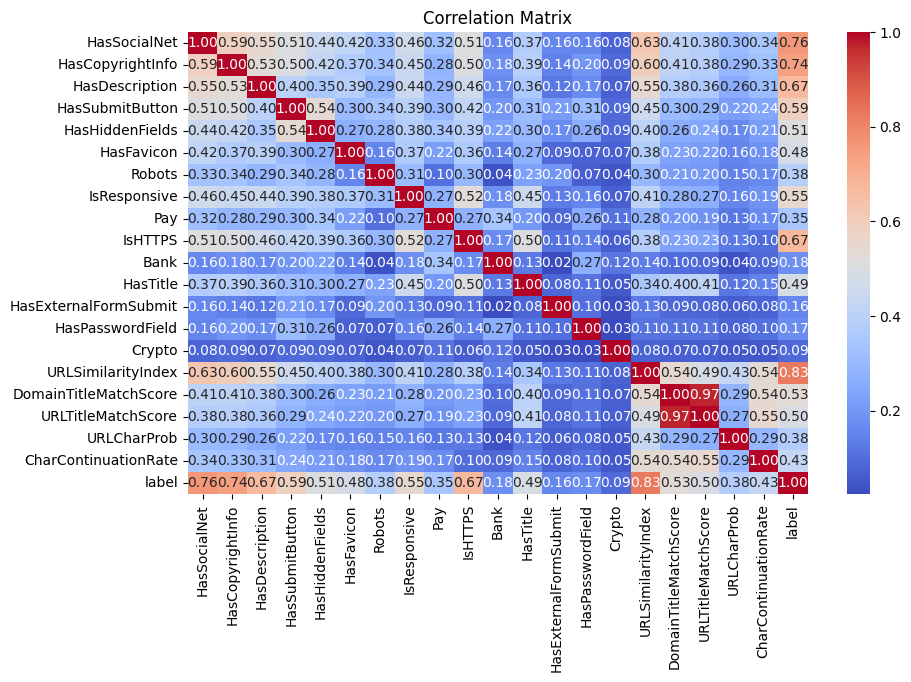

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


### Heatmap sau khi Loại bỏ đặc trưng dư thừa (Multicollinearity)
- DomainTitleMatchScore và URLSimilarityIndex có tương quan 0.97 → Nên giữ lại - URLSimilarityIndex, loại bỏ DomainTitleMatchScore.
- URLTitleMatchScore và URLSimilarityIndex có tương quan 0.79 → Nếu cần, có thể giữ cả hai, nhưng nên thử nghiệm.

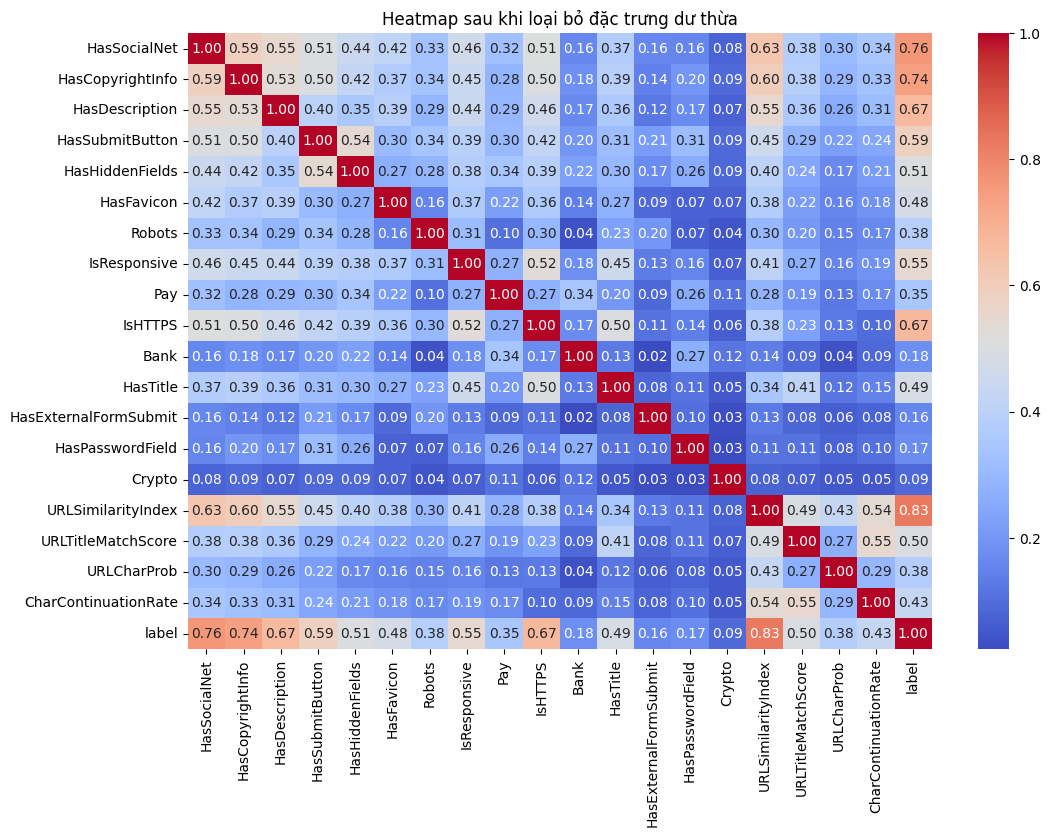

In [ ]:
df_selected = df_selected.drop(columns=["DomainTitleMatchScore"])
plt.figure(figsize=(12, 8))
sns.heatmap(df_selected.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap sau khi loại bỏ đặc trưng dư thừa")
plt.show()

## Model training
🔹 Nếu bạn cần độ chính xác cao, không quan trọng tốc độ huấn luyện:
➝ Gradient Boosting (XGBoost, LightGBM, CatBoost)

🔹 Nếu bạn cần tốc độ huấn luyện nhanh nhưng vẫn hiệu quả:
➝ Random Forest, Decision Tree

🔹 Nếu dữ liệu có mối quan hệ tuyến tính đơn giản:
➝ Logistic Regression, Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from google.colab.data_table import DataTable

X = df_selected.drop(columns=["label"])
y = df_selected["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = []
trained_models = {}

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[model_name] = model

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # Xác suất dự đoán (nếu có)

    # Tính các chỉ số đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    })

results_df = pd.DataFrame(results)

DataTable(results_df)


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.999835,0.999813,0.999925,0.999869,0.999966
1,Gradient Boosting,0.999835,0.999739,1.000000,0.999869,0.999999
2,Logistic Regression,0.999268,0.998844,1.000000,0.999422,0.999993
3,Support Vector Machine,0.999481,0.999179,1.000000,0.999589,0.999999
4,K-Nearest Neighbors,0.997167,0.996166,0.999365,0.997763,0.998689
5,Decision Tree,0.999717,0.999813,0.999739,0.999776,0.999709


# Lưu trữ mô hình đã huấn luyện

In [ ]:
model_dir = "/content/drive/My Drive/Dataset/detect_bad_url_models"
# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(model_dir):
    print("Thư mục chưa tồn tại, hãy kiểm tra quyền truy cập trên Google Drive.")
else:
    print("Thư mục đã tồn tại, tiếp tục lưu mô hình.")

    # Lưu mô hình vào thư mục trên Google Drive
    saved_model_paths = {}
    for model_name, model in trained_models.items():
        file_path = os.path.join(model_dir, f"{model_name.replace(' ', '_')}.pkl")
        joblib.dump(model, file_path)
        saved_model_paths[model_name] = file_path

    print(saved_model_paths)

Thư mục đã tồn tại, tiếp tục lưu mô hình.
{'Random Forest': '/content/drive/My Drive/Dataset/detect_bad_url_models/Random_Forest.pkl', 'Gradient Boosting': '/content/drive/My Drive/Dataset/detect_bad_url_models/Gradient_Boosting.pkl', 'Logistic Regression': '/content/drive/My Drive/Dataset/detect_bad_url_models/Logistic_Regression.pkl', 'Support Vector Machine': '/content/drive/My Drive/Dataset/detect_bad_url_models/Support_Vector_Machine.pkl', 'K-Nearest Neighbors': '/content/drive/My Drive/Dataset/detect_bad_url_models/K-Nearest_Neighbors.pkl', 'Decision Tree': '/content/drive/My Drive/Dataset/detect_bad_url_models/Decision_Tree.pkl'}


# Tải model đã lưu

In [ ]:
model_dir = "/content/drive/My Drive/Dataset/detect_bad_url_models"

if os.path.exists(model_dir):
    print("Đang tải các mô hình đã lưu từ Google Drive...")

    loaded_models = {}
    for model_name in os.listdir(model_dir):
        if model_name.endswith(".pkl"):  # Chỉ tải các file mô hình
            model_path = os.path.join(model_dir, model_name)
            loaded_model = joblib.load(model_path)  # Tải mô hình
            loaded_models[model_name.replace('.pkl', '').replace('_', ' ')] = loaded_model

    print("Tất cả mô hình đã được tải thành công!")
    print(loaded_models)


Đang tải các mô hình đã lưu từ Google Drive...
Tất cả mô hình đã được tải thành công!
{'Random Forest': RandomForestClassifier(random_state=42), 'Gradient Boosting': GradientBoostingClassifier(random_state=42), 'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42), 'Support Vector Machine': SVC(probability=True, random_state=42), 'K-Nearest Neighbors': KNeighborsClassifier(), 'Decision Tree': DecisionTreeClassifier(random_state=42)}


# Kiểm tra overfitting

In [ ]:
# Lưu kết quả kiểm tra Overfitting
overfitting_results = []

# Duyệt qua các mô hình đã huấn luyện
for model_name, model in loaded_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred, zero_division=1)
    train_recall = recall_score(y_train, y_train_pred, zero_division=1)

    test_precision = precision_score(y_test, y_test_pred, zero_division=1)
    test_recall = recall_score(y_test, y_test_pred, zero_division=1)

    overfitting_results.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Overfitting": (train_accuracy - test_accuracy) > 0.05  # Nếu Accuracy trên train lớn hơn test > 5%, có Overfitting
    })

overfitting_df = pd.DataFrame(overfitting_results)

DataTable(overfitting_df)


,Model,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Overfitting
0,Random Forest,1.000000,0.999835,1.000000,0.999813,1.000000,0.999925,False
1,Gradient Boosting,0.999935,0.999835,0.999898,0.999739,1.000000,1.000000,False
2,Logistic Regression,0.999534,0.999268,0.999274,0.998844,0.999991,1.000000,False
3,Support Vector Machine,0.999640,0.999481,0.999432,0.999179,1.000000,1.000000,False
4,K-Nearest Neighbors,0.998064,0.997167,0.997435,0.996166,0.999516,0.999365,False
5,Decision Tree,1.000000,0.999717,1.000000,0.999813,1.000000,0.999739,False


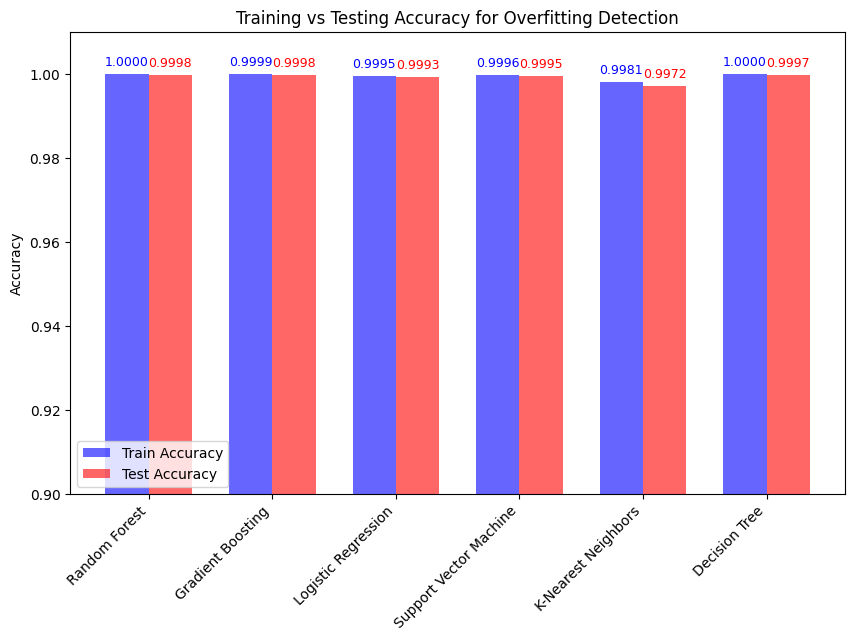

In [ ]:

plt.figure(figsize=(10, 6))
x_labels = overfitting_df["Model"]
x = np.arange(len(x_labels))  # Vị trí của từng mô hình trên trục x
width = 0.35  # Độ rộng của từng cột

# Vẽ cột Train Accuracy
plt.bar(x - width/2, overfitting_df["Train Accuracy"], width, color="blue", alpha=0.6, label="Train Accuracy")

# Vẽ cột Test Accuracy
plt.bar(x + width/2, overfitting_df["Test Accuracy"], width, color="red", alpha=0.6, label="Test Accuracy")

# Thêm giá trị trên mỗi cột
for i in range(len(x_labels)):
    plt.text(x[i] - width/2, overfitting_df["Train Accuracy"][i] + 0.002, f"{overfitting_df['Train Accuracy'][i]:.4f}", ha="center", fontsize=9, color="blue")
    plt.text(x[i] + width/2, overfitting_df["Test Accuracy"][i] + 0.002, f"{overfitting_df['Test Accuracy'][i]:.4f}", ha="center", fontsize=9, color="red")

# Thêm nhãn trục x và định dạng
plt.xticks(x, x_labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy for Overfitting Detection")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.ylim(0.9, 1.01)  # Giới hạn trục y để thấy rõ sự khác biệt

plt.show()

### Kiểm tra Feature Importance

In [ ]:
importances_results = []

# Kiểm tra Feature Importance cho các mô hình có hỗ trợ
for model_name, model in loaded_models.items():
    if hasattr(model, "feature_importances_"):  # Chỉ áp dụng cho các mô hình có feature_importances_
        feature_importances = model.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]  # Sắp xếp giảm dần

        for i in sorted_indices:
            importances_results.append({
                "Model": model_name,
                "Feature": X.columns[i],
                "Importance": feature_importances[i]
            })

# Chuyển kết quả thành DataFrame
importances_df = pd.DataFrame(importances_results)

# Hiển thị bảng Feature Importance
from google.colab.data_table import DataTable
DataTable(importances_df)


,Model,Feature,Importance
0,Random Forest,URLSimilarityIndex,3.692391e-01
1,Random Forest,HasSocialNet,1.921596e-01
2,Random Forest,HasCopyrightInfo,1.170897e-01
3,Random Forest,IsHTTPS,1.002341e-01
4,Random Forest,HasDescription,8.942097e-02
5,Random Forest,URLTitleMatchScore,3.320233e-02
6,Random Forest,HasSubmitButton,2.451402e-02
7,Random Forest,IsResponsive,1.617667e-02
8,Random Forest,HasFavicon,1.441302e-02
9,Random Forest,HasHiddenFields,1.439583e-02


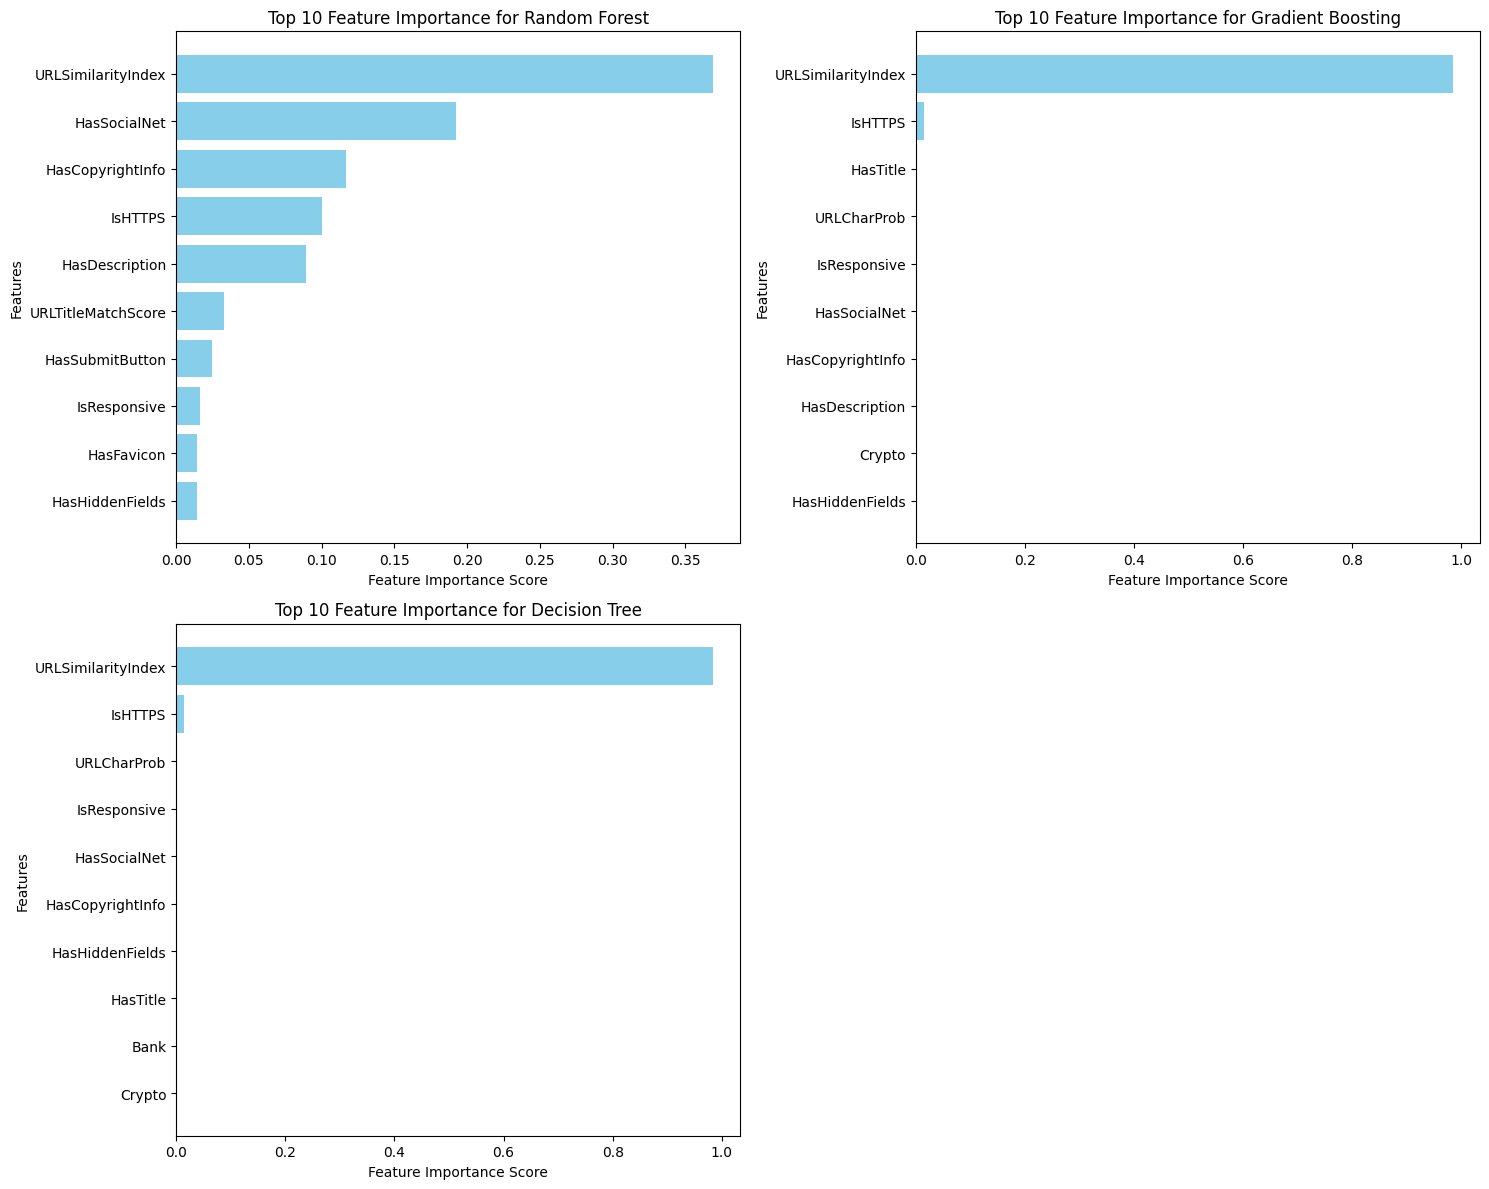

In [ ]:
# Vẽ biểu đồ Feature Importance cho tất cả các mô hình có hỗ trợ
plt.figure(figsize=(15, 12))

# Chọn các mô hình có feature importance
top_models = ["Random Forest", "Gradient Boosting", "Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Decision Tree"]
valid_models = [model for model in top_models if model in importances_df["Model"].unique()]

num_models = len(valid_models)  # Số mô hình có Feature Importance hợp lệ

for i, model_name in enumerate(valid_models):
    top_importances = importances_df[importances_df["Model"] == model_name].nlargest(10, "Importance")

    plt.subplot((num_models + 1) // 2, 2, i+1)  # Chia layout thành nhiều hàng nếu cần
    plt.barh(top_importances["Feature"], top_importances["Importance"], color="skyblue")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(f"Top 10 Feature Importance for {model_name}")
    plt.gca().invert_yaxis()  # Đảo ngược trục y để quan sát dễ hơn

plt.tight_layout()
plt.show()


## Overfitting : Phân tích về Mất Cân Bằng Dữ Liệu

# Khắc phục overfitting
- Regularization
- Giám nhiễu đầu vào
- cross-validtion
- chuẩn hóa dữ liệu

In [ ]:
df_selected["label"].value_counts(normalize=True)

,proportion
label,
1,0.633436
0,0.366564


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from google.colab.data_table import DataTable

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = df_selected.drop(columns=["label"])  # Loại bỏ cột label
y = df_selected["label"]  # Nhãn đầu ra

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loại bỏ URLSimilarityIndex (vì nó gây Overfitting)
X_filtered = X.drop(columns=["URLSimilarityIndex"])

# Chia lại dữ liệu sau khi loại bỏ đặc trưng gây Overfitting
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

#  Áp dụng Regularization & Huấn luyện lại mô hình
models = {
    "Random Forest": RandomForestClassifier(max_depth=10, random_state=42),  # Giới hạn độ sâu
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.01, subsample=0.8, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, penalty='l2', C=0.1, random_state=42),  # L2 Regularization
    "Support Vector Machine": SVC(probability=True, kernel='linear', C=0.1, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
}

trained_models = {}

# Lưu kết quả đánh giá mô hình
results_filtered = []

# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    model.fit(X_train_filtered, y_train)  # Huấn luyện mô hình
    trained_models[model_name] = model  # Lưu lại mô hình đã huấn luyện

    y_pred = model.predict(X_test_filtered)  # Dự đoán trên tập kiểm tra
    y_pred_proba = model.predict_proba(X_test_filtered)[:, 1] if hasattr(model, "predict_proba") else None

    # Tính các chỉ số đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results_filtered.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    })

results_filtered_df = pd.DataFrame(results_filtered)

DataTable(results_filtered_df)


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,0.988880,0.990054,0.992383,0.991217,0.999138
1,Gradient Boosting,0.971055,0.973259,0.981181,0.977204,0.994338
2,Logistic Regression,0.984489,0.987862,0.987604,0.987733,0.998595
3,Support Vector Machine,0.985952,0.989568,0.988201,0.988884,0.998580
4,K-Nearest Neighbors,0.988715,0.989650,0.992532,0.991089,0.995610
5,Decision Tree,0.978138,0.983109,0.982302,0.982705,0.995461


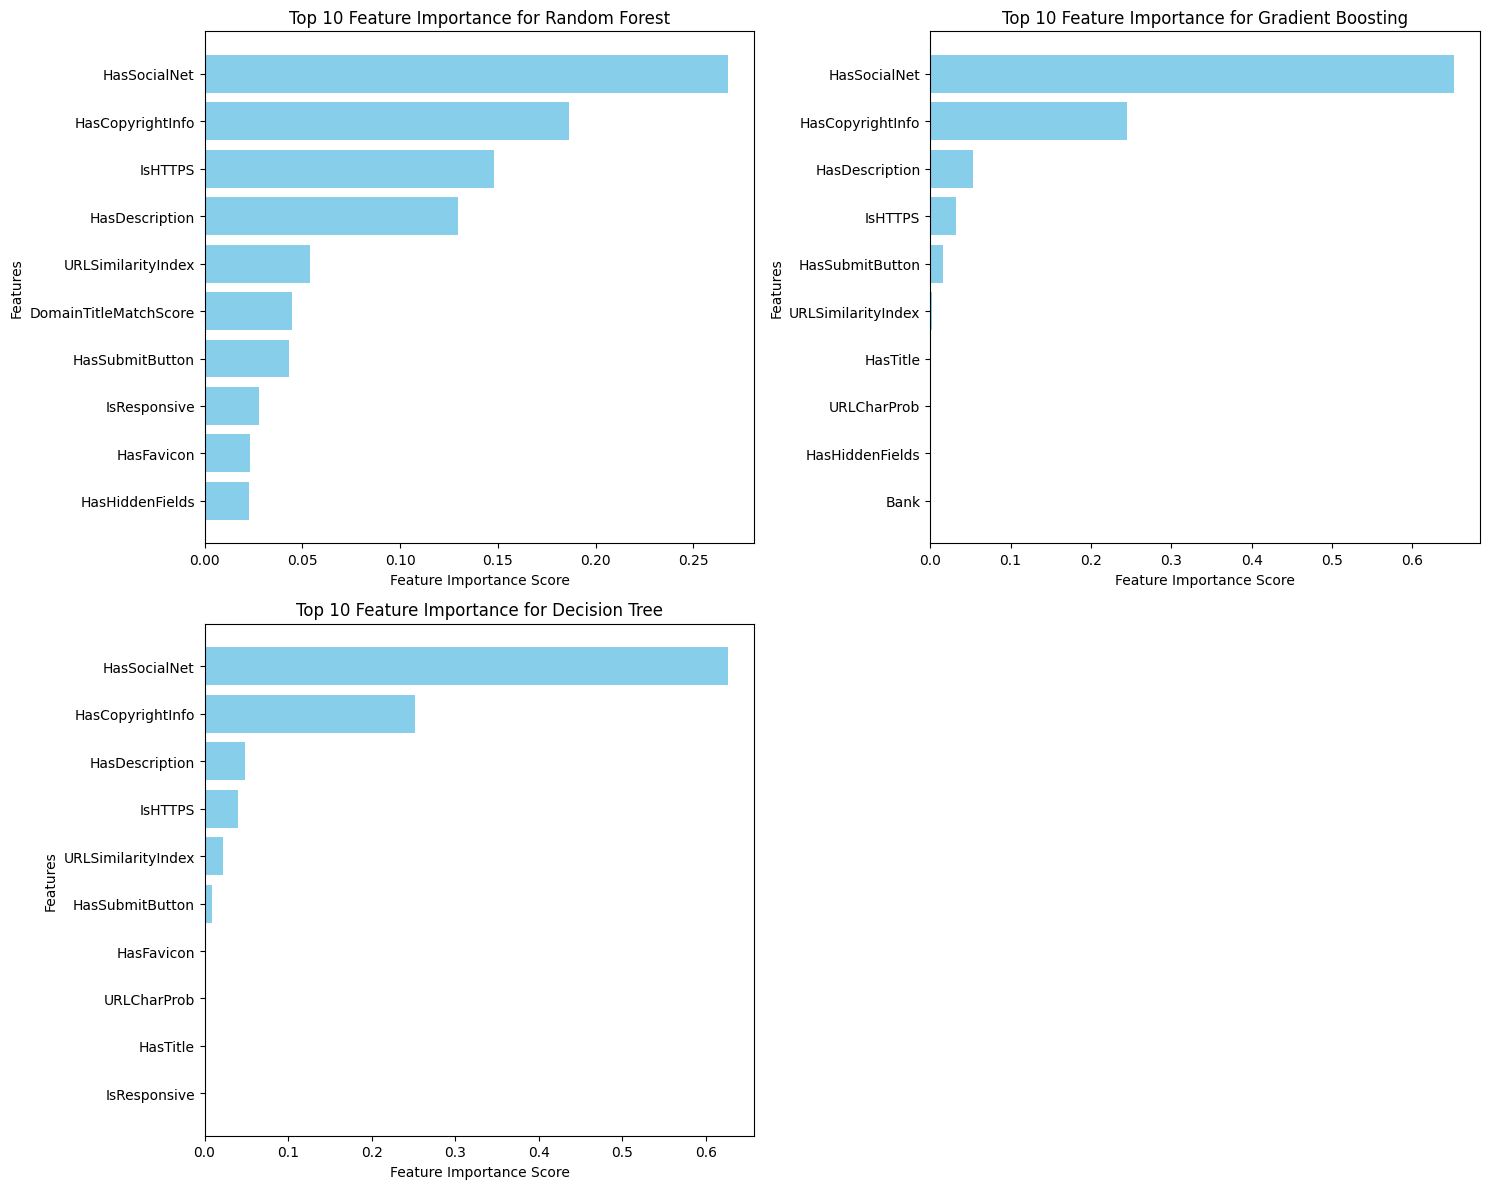

In [ ]:
importances_results = []

# Kiểm tra Feature Importance cho các mô hình có hỗ trợ
for model_name, model in trained_models.items():
    if hasattr(model, "feature_importances_"):  # Chỉ áp dụng cho các mô hình có feature_importances_
        feature_importances = model.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]  # Sắp xếp giảm dần

        for i in sorted_indices:
            importances_results.append({
                "Model": model_name,
                "Feature": X.columns[i],
                "Importance": feature_importances[i]
            })

importances_df = pd.DataFrame(importances_results)

from google.colab.data_table import DataTable
DataTable(importances_df)

# Vẽ biểu đồ Feature Importance cho tất cả các mô hình có hỗ trợ
plt.figure(figsize=(15, 12))

# Chọn các mô hình có feature importance
top_models = ["Random Forest", "Gradient Boosting", "Logistic Regression", "Support Vector Machine", "K-Nearest Neighbors", "Decision Tree"]
valid_models = [model for model in top_models if model in importances_df["Model"].unique()]

num_models = len(valid_models)  # Số mô hình có Feature Importance hợp lệ

for i, model_name in enumerate(valid_models):
    top_importances = importances_df[importances_df["Model"] == model_name].nlargest(10, "Importance")

    plt.subplot((num_models + 1) // 2, 2, i+1)
    plt.barh(top_importances["Feature"], top_importances["Importance"], color="skyblue")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title(f"Top 10 Feature Importance for {model_name}")
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
# Đường dẫn thư mục lưu trữ mô hình trên Google Drive
model_dir = "/content/drive/My Drive/Dataset/fixed_overfitting_models"
# Kiểm tra xem thư mục có tồn tại không
if not os.path.exists(model_dir):
    print("Thư mục chưa tồn tại, hãy kiểm tra quyền truy cập trên Google Drive.")
else:
    print("Thư mục đã tồn tại, tiếp tục lưu mô hình.")

    # Lưu mô hình vào thư mục trên Google Drive
    saved_model_paths = {}
    for model_name, model in trained_models.items():
        file_path = os.path.join(model_dir, f"{model_name.replace(' ', '_')}.pkl")
        joblib.dump(model, file_path)
        saved_model_paths[model_name] = file_path

    print(saved_model_paths)

Thư mục đã tồn tại, tiếp tục lưu mô hình.
{'Random Forest': '/content/drive/My Drive/Dataset/fixed_overfitting_models/Random_Forest.pkl', 'Gradient Boosting': '/content/drive/My Drive/Dataset/fixed_overfitting_models/Gradient_Boosting.pkl', 'Logistic Regression': '/content/drive/My Drive/Dataset/fixed_overfitting_models/Logistic_Regression.pkl', 'Support Vector Machine': '/content/drive/My Drive/Dataset/fixed_overfitting_models/Support_Vector_Machine.pkl', 'K-Nearest Neighbors': '/content/drive/My Drive/Dataset/fixed_overfitting_models/K-Nearest_Neighbors.pkl', 'Decision Tree': '/content/drive/My Drive/Dataset/fixed_overfitting_models/Decision_Tree.pkl'}
